<a href="https://colab.research.google.com/github/anni1st/Anomaly-Detection-VM-/blob/main/anomaly_detection_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
from google.colab import files
uploaded = files.upload()


Saving memory_data.csv to memory_data.csv


In [9]:
data = pd.read_csv('memory_data.csv')
data

,date_time,memory_used,in_gb,in_percent
0,2020-01-03TH:00:24.000000Z,92209370,9.442239,59.01
1,2020-01-03TH:00:59.000000Z,98758823,10.112903,63.21
2,2020-01-04TH:12:24.000000Z,93081576,9.531553,59.57
3,2020-01-04TH:34:46.000000Z,95596292,9.789060,61.18
4,2020-01-04TH:40:05.000000Z,93886601,9.613988,60.09
...,...,...,...,...
995,2023-11-04TH:10:16.000000Z,91742504,9.394432,58.72
996,2023-11-11TH:17:14.000000Z,95192419,9.747704,60.92
997,2023-11-11TH:31:04.000000Z,96704166,9.902507,61.89
998,2023-11-11TH:53:08.000000Z,90032729,9.219351,57.62


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date_time    1000 non-null   object 
 1   memory_used  1000 non-null   int64  
 2   in_gb        1000 non-null   float64
 3   in_percent   1000 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 31.4+ KB


In [14]:
data.isnull().sum()

date_time      0
memory_used    0
in_gb          0
in_percent     0
dtype: int64

In [11]:
data.describe()

,memory_used,in_gb,in_percent
count,1.000000e+03,1000.000000,1000.000000
mean,9.453001e+07,9.679873,60.499320
std,2.532375e+06,0.259315,1.620779
min,9.000809e+07,9.216829,57.610000
25%,9.228278e+07,9.449757,59.060000
50%,9.449288e+07,9.676071,60.475000
75%,9.665419e+07,9.897389,61.860000
max,9.897720e+07,10.135266,63.350000


In [15]:
round(data.describe(),2)

,memory_used,in_gb,in_percent
count,1000.00,1000.00,1000.00
mean,94530014.51,9.68,60.50
std,2532375.01,0.26,1.62
min,90008094.00,9.22,57.61
25%,92282783.00,9.45,59.06
50%,94492878.50,9.68,60.47
75%,96654192.75,9.90,61.86
max,98977204.00,10.14,63.35


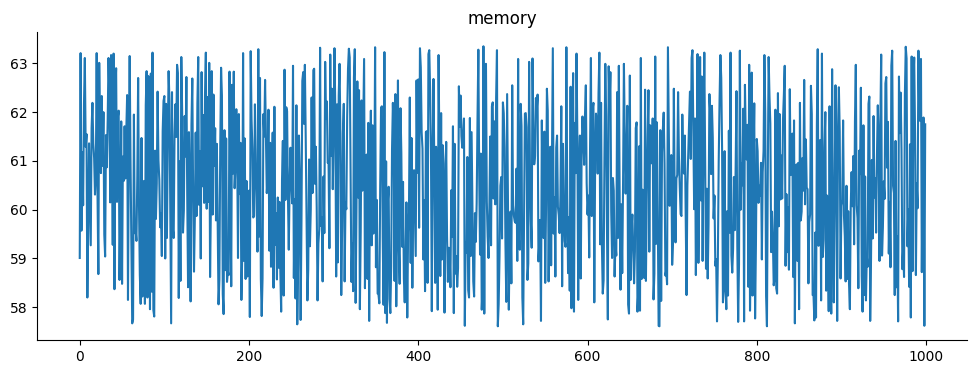

In [13]:
from matplotlib import pyplot as plt
data['in_percent'].plot(kind='line', figsize=(12, 4), title='memory')
plt.gca().spines[['top', 'right']].set_visible(False)

In [16]:
data['date_time'] = data['date_time'].str.replace(' WIB\+0700', '')
data.head

<ipython-input-16-820430e47c73>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['date_time'] = data['date_time'].str.replace(' WIB\+0700', '')


<bound method NDFrame.head of                       date_time  memory_used      in_gb  in_percent
0    2020-01-03TH:00:24.000000Z     92209370   9.442239       59.01
1    2020-01-03TH:00:59.000000Z     98758823  10.112903       63.21
2    2020-01-04TH:12:24.000000Z     93081576   9.531553       59.57
3    2020-01-04TH:34:46.000000Z     95596292   9.789060       61.18
4    2020-01-04TH:40:05.000000Z     93886601   9.613988       60.09
..                          ...          ...        ...         ...
995  2023-11-04TH:10:16.000000Z     91742504   9.394432       58.72
996  2023-11-11TH:17:14.000000Z     95192419   9.747704       60.92
997  2023-11-11TH:31:04.000000Z     96704166   9.902507       61.89
998  2023-11-11TH:53:08.000000Z     90032729   9.219351       57.62
999  2023-11-13TH:31:26.000000Z     96481867   9.879743       61.75

[1000 rows x 4 columns]>

In [18]:
X = data.drop(['in_percent'], axis=1)

y = data['in_percent']

Split data to training and testing sets

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape

((800, 3), (200, 3))

In [20]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale(dataframe):
    scaler = MinMaxScaler()
    return scaler.fit_transform(dataframe)

def split_data(series, train_fraq, test_len=8760):
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)

    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]

    return train_data, val_data, test_data